# Detection probability

...

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

import sys
sys.path.append("../../icecube_tools/")

colormap = plt.cm.viridis

In [2]:
from icecube_tools.detection_probability import (get_simulated_params, 
                                                 get_detection_probability)
from icecube_tools.detection_probability import get_TS_threshold
from icecube_tools.detection_probability import fit_func
from icecube_tools.detector.effective_area import EffectiveArea
from icecube_tools.neutrino_calculator import PhiSolver
from scipy.ndimage.filters import gaussian_filter1d

## Simulation of neutrino detection in IceCube

## Point source search on simulated data

## Calculation of detection probability
This calculation is quite slow (~20 min), but can be run once and the resulting `output/precomputed_pdet_XXX.h5` files can be used in the subsequent sections. These files are provided such that the reader can just skip ahead to the discovery potential comparison.  

In [ ]:
from tqdm.autonotebook import tqdm as progress_bar

In [ ]:
# Use background to set TS thresholds
bg_file = "output/TS_dist_bg_30_3_withE_Nevents497.h5"
with h5py.File(bg_file, 'r') as f:
    dec_to_sim = f["dec_to_sim"][()]
    TS = []
    for dec in dec_to_sim:
        TS.append(f["TS_%.2f" % dec][()])
        
fivesig_level = 5.7e-7/2
TS_th = np.zeros(len(dec_to_sim))
fit_params = []
for i, dec in enumerate(dec_to_sim):
    TS_th[i], out, _ = get_TS_threshold(abs(TS[i]), fivesig_level, 
                                        above=max(TS[i])/4) # 6, 10
    fit_params.append(out)
    
ps = np.polyfit(np.sin(dec_to_sim), TS_th, 3)
poly = np.poly1d(ps)

In [ ]:
# Use injected source sim to find Pdet given above thresholds
source_file = "output/TS_dist_dec_30_3_6_Nevents497.h5"
dec_to_sim, index_to_sim = get_simulated_params(filename)

Pdet_dec = []
for i in progress_bar(range(len(dec_to_sim)), desc='Pdet calc'):
    dec = dec_to_sim[i]
    Pdet_index = []
    for j, index in enumerate(index_to_sim):
        Nsrc_list, P = get_detection_probability(source_file, index, dec,
                                                 poly(np.sin(dec)))
        Pdet_index.append(P)
    Pdet_dec.append(Pdet_index)
Pdet_dec = np.array(Pdet_dec)

In [ ]:
# Write results to file
with h5py.File("ouput/precomputed_pdet_30_3_6_Nevents497_v1.h5", 'w') as f:
    f.create_dataset("dec_to_sim", data=dec_to_sim)
    f.create_dataset("index_to_sim", data=index_to_sim)
    f.create_dataset("Nsrc_list", data=Nsrc_list)
    for i, dec in enumerate(dec_to_sim):
        folder = f.create_group("dec_%.2f" % dec)
        for j, index in enumerate(index_to_sim):
            subfolder = folder.create_group("index_%.2f" % index)
            subfolder.create_dataset("Pdet", data=Pdet_dec[i][j])

## Discovery potential comparison

In [4]:
precomp_file = "output/precomputed_pdet_30_3_6_Nevents497.h5" 

# Read in data
with h5py.File(precomp_file, 'r') as f:
    dec_to_sim = f["dec_to_sim"][()]
    index_to_sim = f["index_to_sim"][()]
    Nsrc_list = f["Nsrc_list"][()]
    Pdet_dec = np.zeros((len(dec_to_sim), len(index_to_sim), len(Nsrc_list)))
    for i, dec in enumerate(dec_to_sim):
        folder = f["dec_%.2f" % dec]
        for j, index in enumerate(index_to_sim):
            subfolder = folder["index_%.2f" % index]
            Pdet_dec[i][j] = subfolder["Pdet"][()]

In [5]:
# Find the 50% level that defines the dsicovery potential for each index
mean_events = []
for j, index in enumerate(index_to_sim):
    me = [np.interp(0.5, P, Nsrc_list) for P in np.transpose(Pdet_dec, (1,0,2))[j]]
    mean_events.append(me)

In [6]:
# Convert expected Nnu from source -> source flux
Aeff_filename = "input/IC86-2012-TabulatedAeff.txt"
effective_area = EffectiveArea(Aeff_filename)

phi_solver = PhiSolver(effective_area=effective_area, Emin=1e3, 
                       time=7.0, max_cosz=0.1, Emax=5e10, Enorm=1e5)

flux = []
for j, index in enumerate(index_to_sim):
    f = [phi_solver(Nnu, np.rad2deg(dec), index) 
         for Nnu, dec in zip(mean_events[j], dec_to_sim)]
    flux.append(f)

### Fig. 2

In [10]:
# Actual values from Fig. 18 in Aartsen+2019
ic_2 = np.loadtxt("input/Aartsen+2019_fig18_2.csv", delimiter=',')
ic_2p19 = np.loadtxt("input/Aartsen+2019_fig18_2p19.csv", delimiter=',')

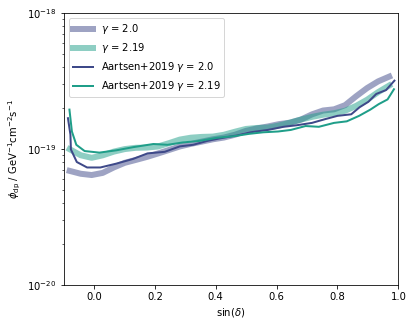

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
colors = colormap(np.linspace(0, 1, 10))

ax.plot(np.sin(dec_to_sim), gaussian_filter1d(flux[1], sigma=1.0), color=colors[2],
            alpha=0.5, label="$\gamma$ = 2.0", linestyle='-', lw=6)
ax.plot(np.sin(dec_to_sim), gaussian_filter1d(flux[2], sigma=1.0), color=colors[5],
            alpha=0.5, label="$\gamma$ = 2.19", linestyle='-', lw=6)
ax.plot(ic_2.T[0], ic_2.T[1], color=colors[2], linestyle='-', 
        label="Aartsen+2019 $\gamma$ = 2.0", lw=2)
ax.plot(ic_2p19.T[0], ic_2p19.T[1], color=colors[5], linestyle='-', 
        label="Aartsen+2019 $\gamma$ = 2.19", lw=2)
ax.set_yscale("log")
ax.set_ylim(1e-20, 1e-18)
ax.legend()
ax.set_xlabel("sin($\delta$)")
ax.set_ylabel("$\phi_\mathrm{dp}$ / $\mathrm{GeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}$");
ax.set_xlim(-0.1, 1);

## Detection probability